In [12]:
import sys

sys.path.append("/lus/swift/home/srajani/.local/conda/2021-09-22/lib/python3.8/site-packages")
sys.argv = ['']

In [13]:
import copy
import math
import os

import torch
from torchvision import datasets, transforms

import numpy as np
from scipy import stats
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from tqdm import tqdm

from options import args_parser
from utils import exp_details, get_train_test, average_weights, get_model
from update import LocalUpdate, test_inference
from sampling import dominant_label_sampling, dirichlet_sampling

In [14]:
# Parse, validate, and print arguments

args = args_parser()

args.local_ep = 5
args.lr = 0.00001
args.supervision = True

exp_details(args)


Experimental details:

Reinforcement Arguments:
    Steps Before PPO Update : 256
    PPO Learning Rate       : 0.0003
    PPO Discount Factor     : 0.9
    PPO Batch Size          : 16
    PPO Total Timesteps     : 15000
    Target Accuracy         : 0.95

Federated Arguments:
    Number of Users         : 100
    Fraction of Users       : 0.1
    Local Epochs            : 1
    Local Batch Size        : 10
    Learning Rate           : 1e-05
    Momentum                : 0.5
    Optimizer               : adam

Model Arguments:
    Supervision             : True
    Model                   : cnn

Misc. Arguments:
    Dataset                 : cifar
    Number of GPUs          : 1
    IID                     : 0
    Unequal                 : 0
    Random Seed             : 1
    Test Fraction           : 1



## The Idea

We train 100 clients for 5 local epochs and use PCA-reduction to visualize their model parameters. We color each point according to its most prominent label.

In [5]:
sampling_type = "dominant_label"

In [6]:
def plot_pca(dataset, model):
    dataset_dir = os.path.join(args.data_path, dataset)
    train_dataset, test_dataset = get_train_test(dataset)

    base_model = get_model(model, dataset, args.supervision, "cuda")
    local_models = [copy.deepcopy(base_model) for _ in range(args.num_users)]

    if sampling_type == "dominant_label":
        dict_users = dominant_label_sampling(train_dataset, num_users=args.num_users, num_samples=50_000, gamma=0.8, print_labels=False)
    if sampling_type == "dirichlet":
        dict_users = dirichlet_sampling(train_dataset, num_users=args.num_users, num_samples=40_000, alpha=0.1, print_labels=False)

    print("Training client fitting models...")
    user_params = []
    for i, user_samples in tqdm(dict_users.items()):
        local_model = local_models[i]
        local_update = LocalUpdate(
            train_dataset,
            user_samples,
            args.local_ep,
            args.local_bs,
            args.lr,
            args.optimizer,
            args.supervision,
            "cuda",
        )
        w, loss = local_update.update_weights(local_model)
        params = torch.cat([p.flatten() for p in local_model.parameters()]).detach().cpu().numpy()
        user_params.append(params)
    
    if dataset == "cifar":
        dataset_name = "CIFAR-10"
    elif dataset == "mnist":
        dataset_name = "MNIST"

    # PCA for fitting model parameters
    n_components = 2
    pca_params_fit = PCA(n_components=n_components).fit_transform(user_params)

    # labels = ["plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

    labels = range(10)

    plt.rcParams.update({'font.size': 20})
    fig = plt.figure(figsize=(8, 8))
    if n_components == 3:
        ax = fig.add_subplot(projection='3d')
    else:
        ax = fig.add_subplot()

    #     for i, params in enumerate(pca_params_fit):
    #         ax.scatter(params[0], params[1], c=dominant_label, vmin=0, vmax=9, label=labels[i] if i < 10 else "", cmap="tab10")
    for i, (user_samples, params) in enumerate(zip(dict_users.values(), pca_params_fit)):
        mode = stats.mode(np.array(train_dataset.targets)[list(user_samples)])
        dominant_label, dominant_label_ratio = mode.mode[0], mode.count[0] / len(user_samples)
    #     ax.scatter(*params, c=dominant_label, vmin=0, vmax=9, alpha=dominant_label_ratio, cmap="tab10", s=60)
        ax.scatter(*params, c=dominant_label, vmin=0, vmax=9, label=labels[i] if i < 10 else "", cmap="tab10", s=60)
    ax.set_title(f"Principal Components of {dataset_name} Client Models", fontsize=18)
    ax.set_xlabel("Principal Component 1")
    ax.set_ylabel("Principal Component 2")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.legend()
    plt.show()

/lus/theta-fs0/software/thetagpu/conda/2021-09-22/mconda3/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:174.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Training client fitting models...


100%|██████████| 1/1 [00:36<00:00, 36.19s/it]


No handles with labels found to put in legend.


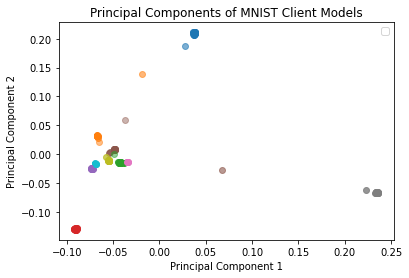

In [7]:
for dataset, model in [("mnist", "mlp"), ("cifar", "cnn")]:
    plot_pca(dataset, model)